In [1]:
import os
import numpy as np
import xarray as xr
import xgcm
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import cartopy
import cartopy.crs as ccrs
import sectionate as sec
import regionate as reg
# Don't display filter warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
def fix_grid_coords(ds, og, sg):
    og['deptho'] = (
        og['deptho'].where(~np.isnan(og['deptho']), 0.)
    )
    if sg is not None:
        og = og.assign_coords({
            'geolon'  : xr.DataArray(sg['x'][1::2,1::2].data, dims=["yh", "xh"]),
            'geolat'  : xr.DataArray(sg['y'][1::2,1::2].data, dims=["yh", "xh"]),
            'geolon_u': xr.DataArray(sg['x'][1::2,0::2].data, dims=["yh", "xq"]),
            'geolat_u': xr.DataArray(sg['y'][1::2,0::2].data, dims=["yh", "xq"]),
            'geolon_v': xr.DataArray(sg['x'][0::2,1::2].data, dims=["yq", "xh"]),
            'geolat_v': xr.DataArray(sg['y'][0::2,1::2].data, dims=["yq", "xh"]),
            'geolon_c': xr.DataArray(sg['x'][0::2,0::2].data, dims=["yq", "xq"]),
            'geolat_c': xr.DataArray(sg['y'][0::2,0::2].data, dims=["yq", "xq"])
        })
    
    ds = ds.assign_coords({
        'dxCv': xr.DataArray(
            og['dxCv'].transpose('xh', 'yq').values, dims=('xh', 'yq',)
        ),
        'dyCu': xr.DataArray(
            og['dyCu'].transpose('xq', 'yh').values, dims=('xq', 'yh',)
        )
    }) # add velocity face widths to calculate distances along the section
    
    ds = ds.assign_coords({
        'areacello':xr.DataArray(og['areacello'].values, dims=("yh", "xh")),
        'geolon':   xr.DataArray(og['geolon'].values, dims=("yh", "xh")),
        'geolat':   xr.DataArray(og['geolat'].values, dims=("yh", "xh")),
        'geolon_u': xr.DataArray(og['geolon_u'].values, dims=("yh", "xq",)),
        'geolat_u': xr.DataArray(og['geolat_u'].values, dims=("yh", "xq",)),
        'geolon_v': xr.DataArray(og['geolon_v'].values, dims=("yq", "xh",)),
        'geolat_v': xr.DataArray(og['geolat_v'].values, dims=("yq", "xh",)),
        'geolon_c': xr.DataArray(og['geolon_c'].values, dims=("yq", "xq",)),
        'geolat_c': xr.DataArray(og['geolat_c'].values, dims=("yq", "xq",)),
        'deptho':   xr.DataArray(og['deptho'].values, dims=("yh", "xh",)),
    })
    return ds

def ds_to_grid(ds, z_coord="zstr", xyloc="outer"):
    coords={
        'X': {'center': 'xh', xyloc: 'xq'},
        'Y': {'center': 'yh', xyloc: 'yq'}
    }
    if "z_l" in ds.dims:
        coords = {
            **coords,
            **{'Z': {'center': 'z_l', 'outer': 'z_i'}}
        }
    elif "rho2_l" in ds.dims:
        coords = {
            **coords,
            **{'Z': {'center': 'rho2_l', 'outer': 'rho2_i'}}
        }
    boundary={"X":"periodic", "Y":"extend", "Z":"extend"}
    
    return xgcm.Grid(ds, coords=coords, boundary=boundary, autoparse_metadata=False)

In [3]:
# -- input field filepaths -- 
umo_fp = '/Volumes/T7 Shield/research/models/NWA12/NWA12_physics_2024_01_bcsupdate_chassignet2017v4/ocean_monthly_z.199301-199712.umo.nc'
vmo_fp = '/Volumes/T7 Shield/research/models/NWA12/NWA12_physics_2024_01_bcsupdate_chassignet2017v4/ocean_monthly_z.199301-199712.vmo.nc'
# -- optional time slicing -- 
# t_s = '2013-01-01'; 
# t_e = '2022-12-31';

In [4]:
# -- build master dataset
mfp = xr.open_mfdataset([umo_fp, vmo_fp]) # .sel(time=slice(t_s,t_e)) # uncomment to slice in time
# -- static grid -- 
og = xr.open_dataset('/Volumes/T7 Shield/research/models/NWA12/NWA12_physics_2024_01_bcsupdate_chassignet2017v4/ocean_monthly.static.nc')
ds = fix_grid_coords(mfp, og, None)
grid = ds_to_grid(ds, xyloc="right")

In [5]:
# region bounds
lon_r = np.array([-67, -64.7, -63.1, -61.75, -61.5, -61.3, -61.1, -60.8, -60.95, -61.15, \
                  -61.6, -64, -72, -77, -79, -82.5, -89.5, -87.15, -84.85, -82.5, -74.2, -72.9, -72.8, -68.65])
lat_r = np.array([18.15, 18.6, 18.3, 17.1, 16.3, 15.5, 14.8, 14.5, 13.85, 13.3, \
                  12.1, 9.5, 8.5, 7.5, 9.25, 8.5, 15.5, 21.15, 21.85, 23, 20.25, 20.1, 19.9, 18.6])

In [6]:
# generate region
region = reg.GriddedRegion("caribbean", lon_r, lat_r, grid)

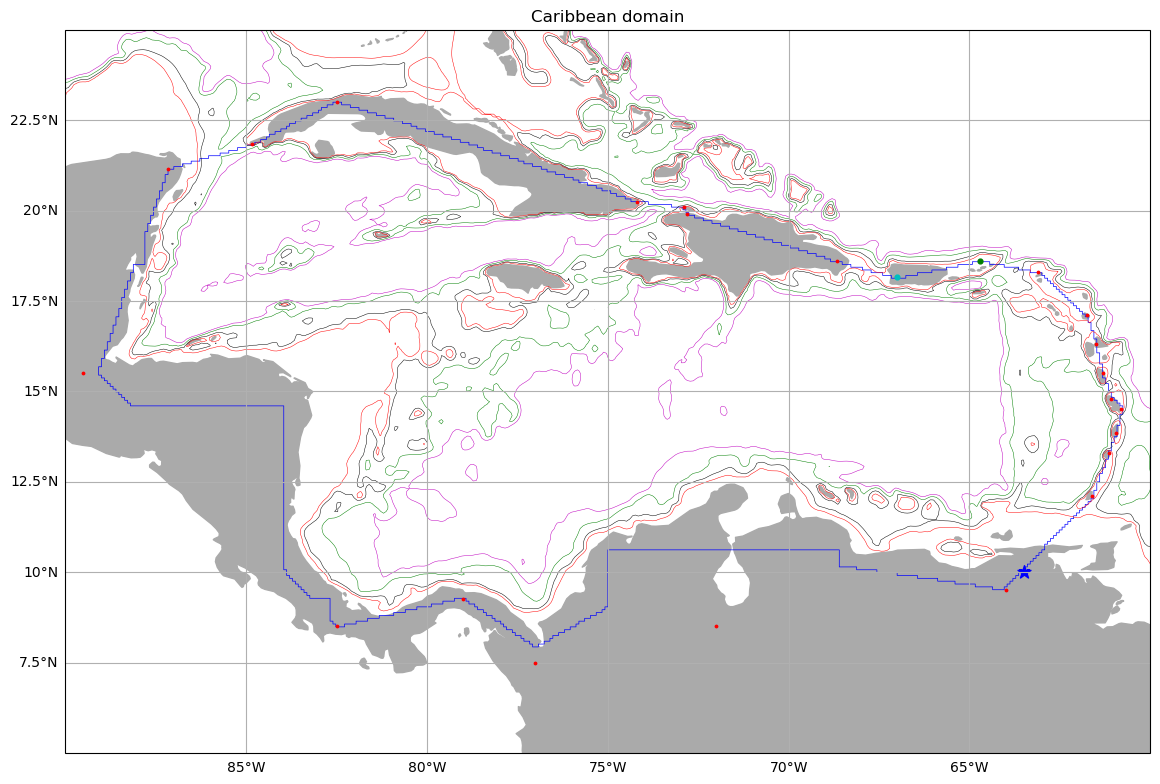

In [7]:
# plot region
background = '#D6CFD3';
f, ax = plt.subplots(1,1,figsize=(14,10), subplot_kw={'projection':ccrs.PlateCarree()})
ax.contour(og.geolon, og.geolat, og.deptho, levels=[500], colors='r', linewidths=0.35, transform=ccrs.PlateCarree())
ax.contour(og.geolon, og.geolat, og.deptho, levels=[1000], colors='k', linewidths=0.35, transform=ccrs.PlateCarree())
ax.contour(og.geolon, og.geolat, og.deptho, levels=[2000], colors='g', linewidths=0.35, transform=ccrs.PlateCarree())
ax.contour(og.geolon, og.geolat, og.deptho, levels=[3000], colors='m', linewidths=0.35, transform=ccrs.PlateCarree())

ax.plot(reg.loop(region.lons_c), reg.loop(region.lats_c), 'b', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=1)
# -- plot region bounding points
for i in range(len(lon_r)):
    if i < 1:
        ax.scatter(lon_r[i],lat_r[i],transform=ccrs.PlateCarree(), color='c', s=12, zorder=3)
    elif (i > 0) & (i < 2):
        ax.scatter(lon_r[i],lat_r[i],transform=ccrs.PlateCarree(), color='g', s=12, zorder=3)
    else:
        ax.scatter(lon_r[i],lat_r[i],transform=ccrs.PlateCarree(), color='r', s=3, zorder=3)
ax.scatter(-63.5,10,color='b',s=96,marker='*')
ax.add_feature(cartopy.feature.LAND, color='#aaaaaa')
ax.set_xlim([-90,-60]); ax.set_ylim([5,25]);
gl = ax.gridlines(draw_labels=True, zorder=0); gl.top_labels = False; gl.right_labels = False;
ax.set_title('Caribbean domain'); 

In [8]:
%%time
ds_sec = sec.convergent_transport(
    grid, region.i_c, region.j_c,
    utr="umo",
    vtr="vmo",
    layer="z_l",
    interface="z_i",
    outname="conv_transport",
    positive_in=region.mask)

convergent_transport = ds_sec['conv_transport']
# cumsum along section\n",
cumulative_convergent_transport = (convergent_transport.cumsum("sect").sel(z_l=ds.z_l[::-1])).compute()

# cumsum along section\n",
cumulative_convergent_transport = (convergent_transport.cumsum("sect").sel(z_l=ds.z_l[::-1])).compute()
# smooth in along section (3 gridcell step)\n",
cumulative_convergent_transport_s = cumulative_convergent_transport.rolling(sect=3).mean()
# along section derivative to get back to a flux \n",
cumulative_convergent_transport_d = cumulative_convergent_transport_s.differentiate('sect',2) #/cumulative_convergent_transport.dl.cumsum('sect').differentiate('sect',2)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


CPU times: user 1min 29s, sys: 5min 47s, total: 7min 16s
Wall time: 7min 30s


In [9]:
%%time
ct = convergent_transport.load()
ct_mean = ct.sel(z_l=ds.z_l[::-1]).cumsum('z_l').mean(dim='time')
da_plot = (ct_mean).where(ct_mean!=0.).swap_dims({'sect':'distance'})
as_dist = convergent_transport.dl.cumsum('sect')/1000

CPU times: user 42.4 s, sys: 2min 35s, total: 3min 17s
Wall time: 3min 24s


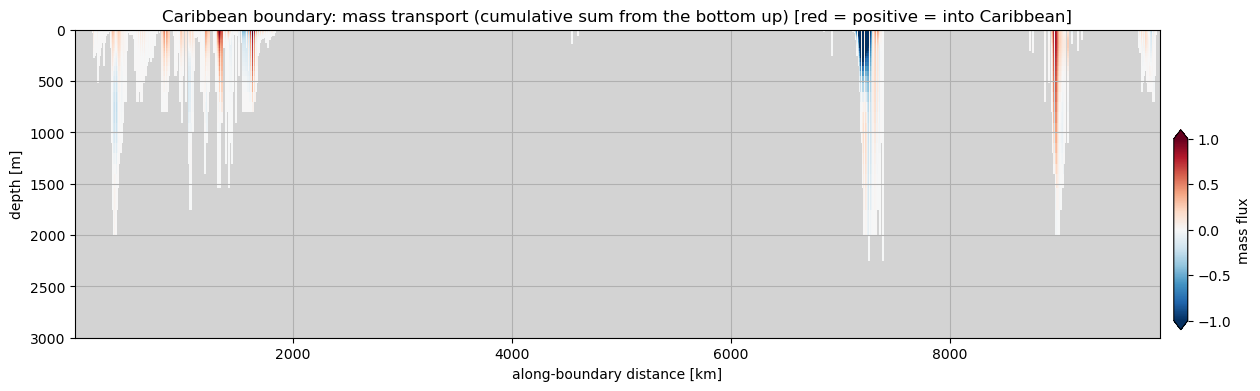

In [12]:
vli = [-1,1]
f, ax = plt.subplots(1,1,figsize=(14,4))
pc = ax.pcolor(as_dist, da_plot.z_l, da_plot/1e9, vmin=vli[0], vmax=vli[1], cmap=plt.get_cmap('RdBu_r'))
# ax.contour(as_dist, da_plot.z_l, da_plot/1e9, levels=[0], colors='k', linewidths=0.25)
ax.set_facecolor("#D3D3D3")
# ax.set_xlim([1250,6000]); 
ax.set_ylim([0,3000]); 
ax.invert_yaxis();
ax.set_title('Caribbean boundary: mass transport (cumulative sum from the bottom up) [red = positive = into Caribbean]'); 
ax.set_ylabel('depth [m]');
ax.set_xlabel('along-boundary distance [km]')
cbpos = [0.91, 0.13, 0.01, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(pc, cax=cax, orientation='vertical', extend='both', label='mass flux');
ax.grid()

In [13]:
cct = ct.sel(z_l=ds.z_l[::-1]).cumsum('z_l').isel(z_l=-1)
cct_smoothed = ct.sel(z_l=ds.z_l[::-1]).cumsum('z_l').isel(z_l=-1).cumsum("sect").rolling(sect=3).mean().differentiate('sect',2)
cct_smoothed = cct_smoothed.swap_dims({'sect':'distance'})

In [14]:
caribbean_mass_trans = cct_smoothed.mean(dim='time')
caribbean_mass_trans_std = cct_smoothed.std(dim='time')

months = [12,1,2]
caribbean_mass_trans_win = cct_smoothed.sel(time=cct_smoothed.time.dt.month.isin(months)).mean(dim='time')
months = [7,8,9]
caribbean_mass_trans_sum = cct_smoothed.sel(time=cct_smoothed.time.dt.month.isin(months)).mean(dim='time')

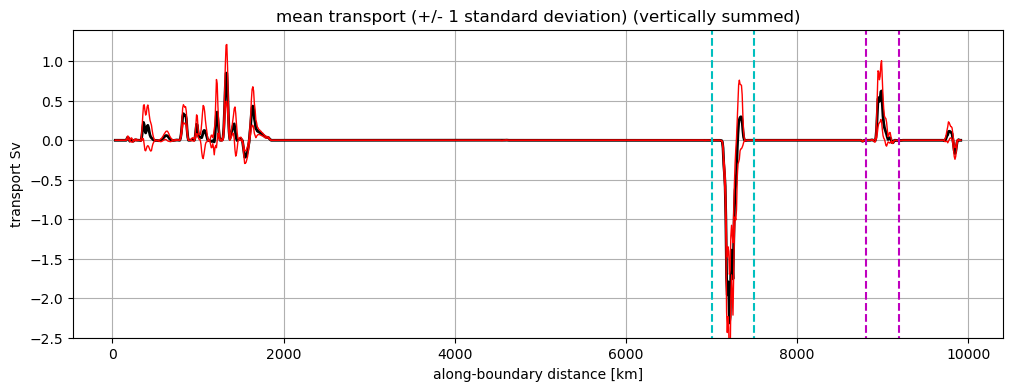

In [15]:
f, ax = plt.subplots(1,1,figsize=(12,4))
ax.plot(as_dist, caribbean_mass_trans/1e9, color='k',linewidth=2)
ax.plot(as_dist, (caribbean_mass_trans + caribbean_mass_trans_std)/1e9, color='r', linewidth=1)
ax.plot(as_dist, (caribbean_mass_trans - caribbean_mass_trans_std)/1e9, color='r', linewidth=1)

# check passage mapping (for map below)
si_e = np.where( (as_dist > 7000) & (as_dist < 7500))[0]
ax.plot([as_dist[si_e[0]], as_dist[si_e[0]]], [-3,1.5], linestyle='--', color='c')
ax.plot([as_dist[si_e[-1]], as_dist[si_e[-1]]], [-3,1.5], linestyle='--', color='c') 

si_e_2 = np.where( (as_dist > 8800) & (as_dist < 9200))[0]
ax.plot([as_dist[si_e_2[0]], as_dist[si_e_2[0]]], [-3,1.5], linestyle='--', color='m')
ax.plot([as_dist[si_e_2[-1]], as_dist[si_e_2[-1]]], [-3,1.5], linestyle='--', color='m') 

ax.set_ylim([-2.5,1.4]); # ax.set_xlim([1250,6000]); 
ax.set_xlabel('along-boundary distance [km]') # note zero distance is arbitrary (plotted on map below)
ax.set_ylabel('transport Sv');
ax.set_title('mean transport (+/- 1 standard deviation) (vertically summed)') 
ax.grid()

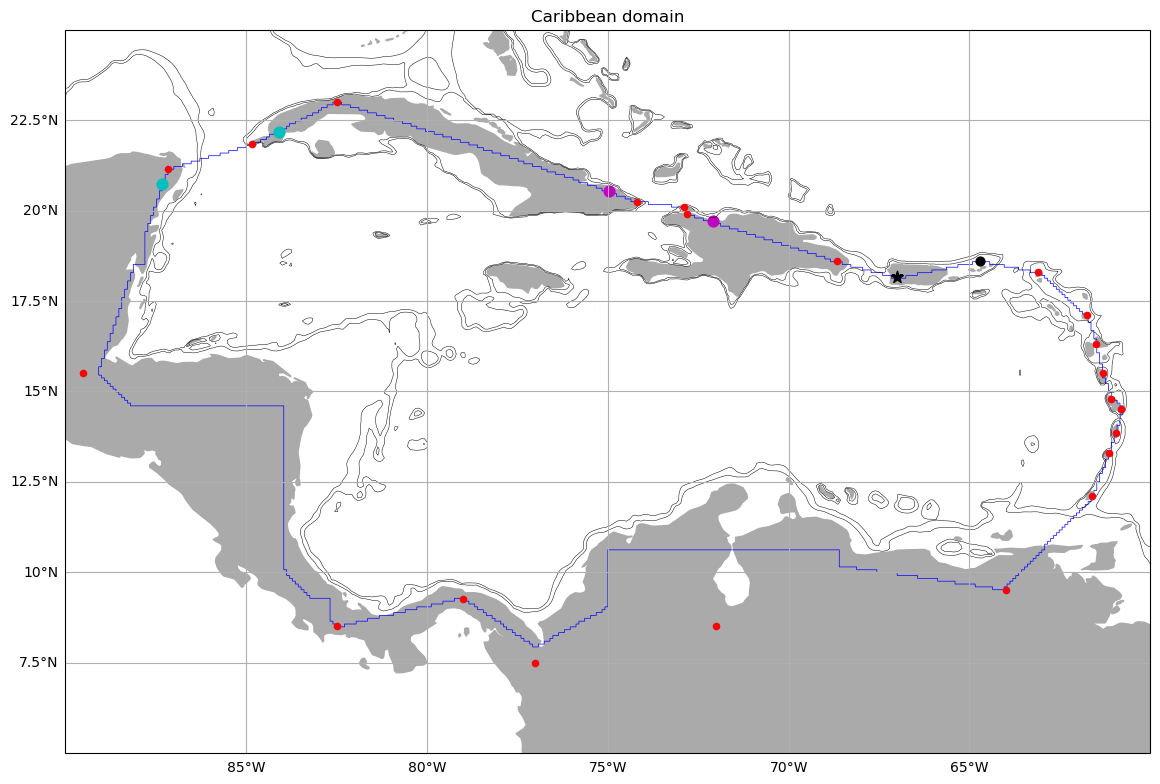

In [16]:
# plot region
background = '#D6CFD3';
f, ax = plt.subplots(1,1,figsize=(14,10), subplot_kw={'projection':ccrs.PlateCarree()})
ax.contour(og.geolon, og.geolat, og.deptho, levels=[500,1000], colors='k', linewidths=0.35, transform=ccrs.PlateCarree())
ax.plot(reg.loop(region.lons_c), reg.loop(region.lats_c), 'b', linewidth=0.5, transform=ccrs.PlateCarree(), zorder=1)

# make sure we have just one region
ax.scatter(ct.lon[si_e[0]], ct.lat[si_e[0]], s=60, c='c', transform=ccrs.PlateCarree(), zorder=1)
ax.scatter(ct.lon[si_e[-1]], ct.lat[si_e[-1]], s=60, c='c', transform=ccrs.PlateCarree(), zorder=1)
ax.scatter(ct.lon[si_e_2[0]], ct.lat[si_e_2[0]], s=60, c='m', transform=ccrs.PlateCarree(), zorder=1)
ax.scatter(ct.lon[si_e_2[-1]], ct.lat[si_e_2[-1]], s=60, c='m', transform=ccrs.PlateCarree(), zorder=1)

# -- plot region bounding points
for i in range(len(lon_r)): # loop over all boundary points
    if i < 1:
        ax.scatter(lon_r[i],lat_r[i],transform=ccrs.PlateCarree(), color='k', marker='*', s=80, zorder=3) # STARTING POINT
    elif (i > 0) & (i < 2):
        ax.scatter(lon_r[i],lat_r[i],transform=ccrs.PlateCarree(), color='k', s=40, zorder=3) # SECOND POINT 
    else:
        ax.scatter(lon_r[i],lat_r[i],transform=ccrs.PlateCarree(), color='r', s=20, zorder=3) 
ax.add_feature(cartopy.feature.LAND, color='#aaaaaa')
ax.set_xlim([-90,-60]); ax.set_ylim([5,25]);
gl = ax.gridlines(draw_labels=True, zorder=0); gl.top_labels = False; gl.right_labels = False;
ax.set_title('Caribbean domain'); 

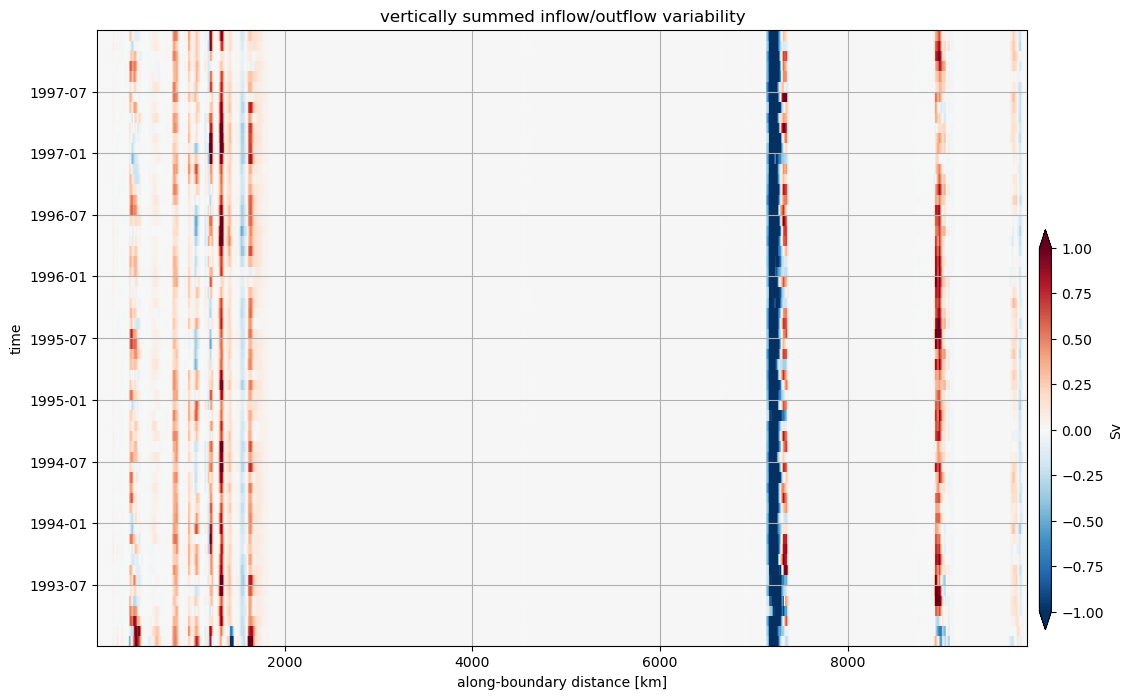

In [17]:
f, ax = plt.subplots(1,1,figsize=(12,8))
cc = ax.pcolor(as_dist, cct_smoothed.time, cct_smoothed/1e9, vmin=-1, vmax=1, cmap=plt.get_cmap('RdBu_r'))
ax.set_xlabel('along-boundary distance [km]'); ax.set_ylabel('time'); ax.grid();
ax.set_title('vertically summed inflow/outflow variability')
cbpos = [0.91, 0.13, 0.01, 0.5]; cax = f.add_axes(cbpos); 
cb = f.colorbar(cc, cax=cax, orientation='vertical', extend='both', label='Sv');